# CS579: Lecture 07  

**Link Prediction**

*[Dr. Aron Culotta](http://cs.iit.edu/~culotta)*  
*[Illinois Institute of Technology](http://iit.edu)*

# Goal:

- Given a graph $G$ at time $t$, predict which edges will be added at time $t+1$.

# Applications?

<br><br><br><br>
- Introduce potential friends 
- Introduce potential collaborators
- Recommend a movie

## What information can we use to recommend friends?

<br><br><br>

- friends of friends
- similar attributes (e.g., same schools)

<br><br>

- The methods we'll discuss today only consider graph structure.
- We'll look at attribute-based approaches in the second part of the course.

## Let's revisit the co-authorship dataset

- Each node is an author
- Undirected edges link co-authors

In [1]:
import warnings
warnings.filterwarnings("ignore")
import networkx as nx
import urllib.request
# Fetch co-author network from http://snap.stanford.edu/data/ca-GrQc.html
# urllib.request.urlretrieve("http://snap.stanford.edu/data/ca-GrQc.txt.gz", "ca-GrQc.txt.gz")
graph = nx.read_edgelist('ca-GrQc.txt.gz')

In [2]:
# How many nodes in graph?
graph.order()

5242

## First, we'll pick a random author

The one with the 500th most co-authors

In [27]:
degrees = graph.degree()
author = sorted(degrees.items(),
                key=lambda x: x[1],
                reverse=True)[500][0]
print('selected author %s with degree %d' % (author, graph.degree(author)))
# author = 13813

selected author 2443 with degree 13


## Next, let's draw the subgraph around this author

- Can't visualize the entire graph very easily.
- Instead, draw the neighborhood of one author.

In [28]:
help(nx.subgraph)

Help on function subgraph in module networkx.classes.function:

subgraph(G, nbunch)
    Return the subgraph induced on nodes in nbunch.
    
    Parameters
    ----------
    G : graph
       A NetworkX graph
    
    nbunch : list, iterable
       A container of nodes that will be iterated through once (thus
       it should be an iterator or be iterable).  Each element of the
       container should be a valid node type: any hashable type except
       None.  If nbunch is None, return all edges data in the graph.
       Nodes in nbunch that are not in the graph will be (quietly)
       ignored.
    
    Notes
    -----
    subgraph(G) calls G.subgraph()



In [29]:
def get_subgraph(graph, nodes, n=100):
    """ Get the subgraph consisting of a list node
    and their neighbors, plus their neighbors'
    neighbors, up to $n$ total nodes"""
    neighbors = set()
    for ni in nodes:
        neighbors |= set(graph.neighbors(ni))
    # plot at least the target node and his neighbors.
    result = set(nodes) | neighbors
    # add "friends of friends" up to n total nodes.
    for x in neighbors:
        # how many more nodes can we add?
        maxsize = n - len(result) 
        toadd = set(graph.neighbors(x)) - result
        result.update(list(toadd)[:maxsize])
        if len(result) > n:
            break
    return graph.subgraph(result)

subgraph = get_subgraph(graph, [author], n=30)
print('subgraph has %d nodes' % len(subgraph.nodes()))

subgraph has 30 nodes


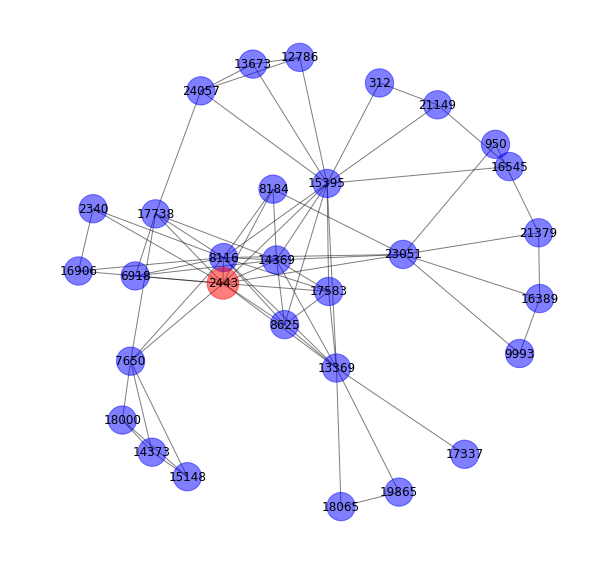

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_subgraph(subgraph, target_nodes):
    """
    Plot this subgraph of nodes, coloring
    the specified list of target_nodes in red.
    """
    nodes = list(subgraph.nodes())
    colors = ['b'] * len(nodes)
    for n in target_nodes:
        idx = nodes.index(n)
        colors[idx] = 'r'
    sizes = [800] * len(nodes)
    sizes[idx] = 1000
    plt.figure(figsize=(10,10))
    plt.axis('off')
    nx.draw_networkx(subgraph, nodelist=nodes, with_labels=True,
                     width=1, node_color=colors,
                     node_size=sizes, alpha=.5)

plot_subgraph(subgraph, [author])

# Approaches


Treat **link prediction** as a **ranking problem.**


- Score each possible new edge $s(X,Y)$.
- Rank all possible edges in descending order of $s(X,Y)$.
- Higher $s(X,Y)$ $\rightarrow$ more likely for the edge to appear.


<br><br>

Let's look at a few possible ranking functions:

<br><br><br>


1.) **Shortest Path:** $s(X,Y) = $ length of shortest path from $X$ to $Y$.


<br><br><br>
Advantages? Disadvantages?

In [7]:
def rank_by_shortest_path(graph, node):
    """
    Score each potential edge from target node X to another 
    node Y by the length of the shortest path from X to Y.
    
    Params:
      graph: networkx Graph
      node: target node to recommend an edge for
    Returns:
      List of (id, score) tuples for edges from node to id.
    """
    paths = nx.shortest_path_length(graph, node)
    return sorted(paths.items(), key=lambda x: x[1])

shortest_paths = rank_by_shortest_path(graph, author)
print('top predicted edges:')
[s for s in shortest_paths if s[1] == 2]
# Many shortest paths of length 2!
# No way to choose among them!

top predicted edges:


[('17823', 2),
 ('16946', 2),
 ('2623', 2),
 ('312', 2),
 ('17819', 2),
 ('12786', 2),
 ('25977', 2),
 ('7991', 2),
 ('24474', 2),
 ('9993', 2),
 ('1293', 2),
 ('10983', 2),
 ('12802', 2),
 ('17600', 2),
 ('3066', 2),
 ('24479', 2),
 ('5302', 2),
 ('22901', 2),
 ('24057', 2),
 ('6525', 2),
 ('18000', 2),
 ('2621', 2),
 ('9433', 2),
 ('17337', 2),
 ('6056', 2),
 ('19865', 2),
 ('26039', 2),
 ('11609', 2),
 ('21149', 2),
 ('21379', 2),
 ('18444', 2),
 ('18065', 2),
 ('3283', 2),
 ('3820', 2),
 ('13526', 2),
 ('950', 2),
 ('6868', 2),
 ('9889', 2),
 ('3812', 2),
 ('4834', 2),
 ('22457', 2),
 ('24615', 2),
 ('14373', 2),
 ('6456', 2),
 ('14157', 2),
 ('17824', 2),
 ('13482', 2),
 ('6222', 2),
 ('7525', 2),
 ('8448', 2),
 ('16545', 2),
 ('13673', 2),
 ('22324', 2),
 ('16389', 2),
 ('3824', 2),
 ('5131', 2),
 ('15148', 2)]

In [8]:
#harish: intersection of neighbourse

# Approaches

**Idea:** If $X$ and $Y$ have many co-authors who have co-authored, then $X$ and $Y$ are more likely to co-author.

<br><br><br>

 2.) **Common Neighbors:** $$|N(X) \cap N(Y)|$$
 
 - where $N(X)$ is the set of neighbors of X

Histogram of number of nodes with common neighbors:
 [(1, 55), (2, 5), (5, 4), (3, 3), (4, 1), (9, 1), (12, 1), (13, 1)]


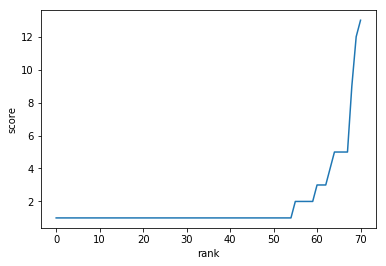

top predicted edges:


[('2443', 13),
 ('8116', 12),
 ('14369', 9),
 ('15395', 5),
 ('13369', 5),
 ('8625', 5),
 ('17583', 5),
 ('17738', 4),
 ('23051', 3),
 ('6918', 3),
 ('8184', 3),
 ('25977', 2),
 ('2340', 2),
 ('24057', 2),
 ('7650', 2),
 ('16906', 2),
 ('16946', 1),
 ('2623', 1),
 ('312', 1),
 ('13482', 1)]

In [9]:
from collections import Counter

def rank_by_common_neighbors(graph, node):
    """
    Score each potential edge from target node X to another 
    node Y by the number of neighbors in common.
    
    Params:
      graph: networkx Graph
      node: target node to recommend an edge for
    Returns:
      List of (id, score) tuples for edges from node to id.
    """
    neighbors = set(graph.neighbors(node))
    scores = []
    for n in graph.nodes():
        neighbors2 = set(graph.neighbors(n))
        scores.append((n, len(neighbors & neighbors2)))
    return sorted(scores, key=lambda x: x[1], reverse=True)

common_neighbors = rank_by_common_neighbors(graph, author)
nonzero_scores = [x[1] for x in common_neighbors if x[1] > 0]
print('Histogram of number of nodes with common neighbors:\n', \
    Counter(nonzero_scores).most_common())

# plot scores
plt.figure()
plt.plot(sorted(nonzero_scores))
plt.xlabel('rank')
plt.ylabel('score')
plt.show()

print('top predicted edges:')
common_neighbors[:20]

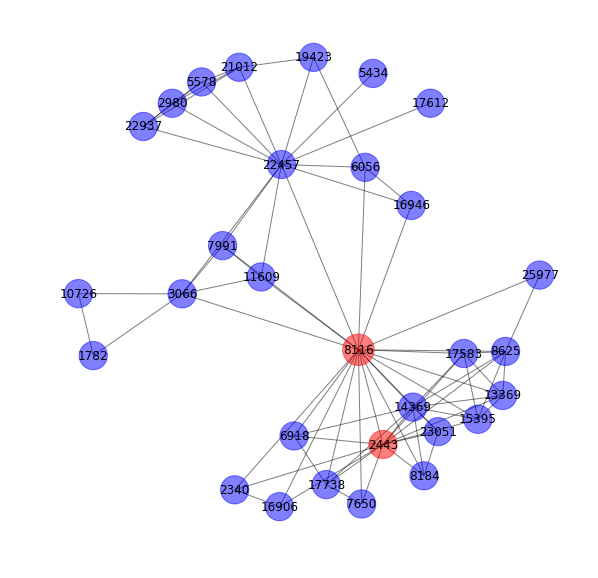

In [30]:
pair = set([author, '8116'])
plot_subgraph(get_subgraph(graph, pair, n=30), pair)

In [11]:
#harish:

# Approaches

**Idea:** If $X$ and $Y$ have many co-authors who have co-authored, then $X$ and $Y$ are more likely to co-author.

 3.) **Jaccard coefficient:** $$\frac{|N(X) \cap N(Y)|}{|N(X) \cup N(Y)|}$$
 
 For a randomly selected node $Z \in N(X) \cup N(Y)$, how likely is it that $Z$ is in both $N(X)$ and $N(Y)$?

In [12]:
def rank_by_jaccard(graph, node):
    neighbors = set(graph.neighbors(node))
    scores = []
    for n in graph.nodes():
        neighbors2 = set(graph.neighbors(n))
        scores.append((n, len(neighbors & neighbors2) /
                          len(neighbors | neighbors2)))
    return sorted(scores, key=lambda x: x[1], reverse=True)

common_jaccard = rank_by_jaccard(graph, author)
common_jaccard[:20]

[('2443', 1.0),
 ('14369', 0.6428571428571429),
 ('8116', 0.5714285714285714),
 ('17583', 0.35714285714285715),
 ('8625', 0.3333333333333333),
 ('13369', 0.29411764705882354),
 ('15395', 0.25),
 ('17738', 0.23529411764705882),
 ('6918', 0.21428571428571427),
 ('8184', 0.21428571428571427),
 ('23051', 0.16666666666666666),
 ('25977', 0.15384615384615385),
 ('2340', 0.14285714285714285),
 ('16906', 0.13333333333333333),
 ('312', 0.07142857142857142),
 ('17337', 0.07142857142857142),
 ('16545', 0.07142857142857142),
 ('16946', 0.06666666666666667),
 ('21149', 0.06666666666666667),
 ('7991', 0.0625)]

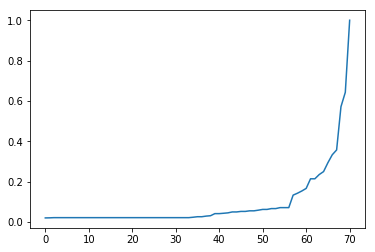

In [13]:
plt.plot(sorted([x[1] for x in common_jaccard if x[1] > 0]))

## How does Jaccard differ from Common Neighbors?


In [14]:
# Print the top 10 jaccard scores, and
# compare with common neighbors scores.
import pandas as pd

def compare_scores(scores_list, names, n):
    """
    Find top n scores for each method and compare.
    """
    ids = set()
    for scores in scores_list:
        ids.update([x[0] for x in scores[:n]])
    print('%d shared ids in top %d' % (len(ids), n))
    results = []
    # find rank and score for each id by each scoring metric.
    for id_ in ids:
        result = {'id': id_}
        for scores, name in zip(scores_list, names):
            for rank, (id2, score) in enumerate(scores):
                if id2 == id_:
                    result[name + '_rank'] = rank
                    result[name + '_score'] = score
                    break
        results.append(result)
    headers = ['id']
    for name in names:
        headers.append(name + '_rank')
        headers.append(name + '_score')
    return pd.DataFrame(results, columns=headers)
    
df = compare_scores([common_jaccard, common_neighbors],
               ['jaccard', 'common neighbors'],
               20)

df.sort_values('jaccard_rank').head(10)

24 shared ids in top 20


,id,jaccard_rank,jaccard_score,common neighbors_rank,common neighbors_score
23,2443,0,1.000000,0,13
10,14369,1,0.642857,2,9
1,8116,2,0.571429,1,12
18,17583,3,0.357143,6,5
12,8625,4,0.333333,5,5
8,13369,5,0.294118,4,5
5,15395,6,0.250000,3,5
21,17738,7,0.235294,7,4
6,6918,8,0.214286,9,3
14,8184,9,0.214286,10,3


In [31]:
# Look at one discrepancy:
set(graph.neighbors(author)) & set(graph.neighbors('17583'))

{'13369', '14369', '15395', '8116', '8625'}

In [16]:
# graph.neighbors('8680')

['20344', '23204', '19204', '13813', '17559']

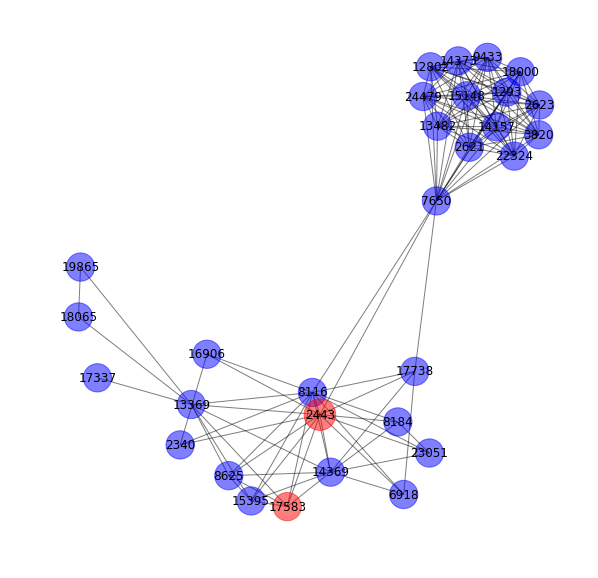

In [32]:
pair = set([author, '17583'])
plot_subgraph(get_subgraph(graph, pair, n=30), pair)

In [18]:
#harish:

# Approaches
 5.) **Adamic / Adar:** 
 
- Downweight each node in the neighbor intersection by the degree of that node.

(e.g., the fact that we both follow CNN is less interesting than that we both follow the Chicago Tribune)
 
$$\sum_{z \in N(X) \cap N(Y)} \frac{1}{\log(|N(z)|)}$$
 
 

In [19]:
import math

def rank_by_adar(graph, node):
    neighbors = set(graph.neighbors(node))
    scores = []
    for n in graph.nodes():
        neighbors2 = set(graph.neighbors(n))
        if n == 'B':
            print('n2=', neighbors2)
            print('n2andn=', neighbors & neighbors2)
        score = sum(1/math.log10(len(list(graph.neighbors(o))))
                    for o in neighbors & neighbors2)
        scores.append((n, score))
    return sorted(scores, key=lambda x: x[1], reverse=True)

adar = rank_by_adar(graph, author)
adar[:20]

[('2443', 16.14268091500121),
 ('8116', 15.374059128160972),
 ('14369', 10.748140528219738),
 ('15395', 5.28496529537834),
 ('13369', 5.163642066262774),
 ('8625', 5.028299040952528),
 ('17583', 4.926496494468998),
 ('17738', 4.06725889933233),
 ('23051', 3.429585834283922),
 ('6918', 2.8759311518026944),
 ('8184', 2.8759311518026944),
 ('16906', 2.8645250611296253),
 ('2340', 2.429585834283922),
 ('24057', 2.033937772991581),
 ('25977', 1.951916449295179),
 ('7650', 1.8759311518026949),
 ('9889', 1.660964047443681),
 ('9993', 1.1073093649624541),
 ('5302', 1.1073093649624541),
 ('21379', 1.1073093649624541)]

In [20]:
df = compare_scores([adar, common_jaccard, common_neighbors],
                    ['adar', 'jaccard', 'common neighbors'],
                    20)

df.sort_values('adar_rank').head(10)

28 shared ids in top 20


,id,adar_rank,adar_score,jaccard_rank,jaccard_score,common neighbors_rank,common neighbors_score
27,2443,0,16.142681,0,1.000000,0,13
1,8116,1,15.374059,2,0.571429,1,12
11,14369,2,10.748141,1,0.642857,2,9
6,15395,3,5.284965,6,0.250000,3,5
9,13369,4,5.163642,5,0.294118,4,5
14,8625,5,5.028299,4,0.333333,5,5
21,17583,6,4.926496,3,0.357143,6,5
24,17738,7,4.067259,7,0.235294,7,4
22,23051,8,3.429586,10,0.166667,8,3
7,6918,9,2.875931,8,0.214286,9,3


In [33]:
# Look at one discrepancy:
set(graph.neighbors(author)) & set(graph.neighbors('15395'))

{'13369', '14369', '17583', '8116', '8625'}

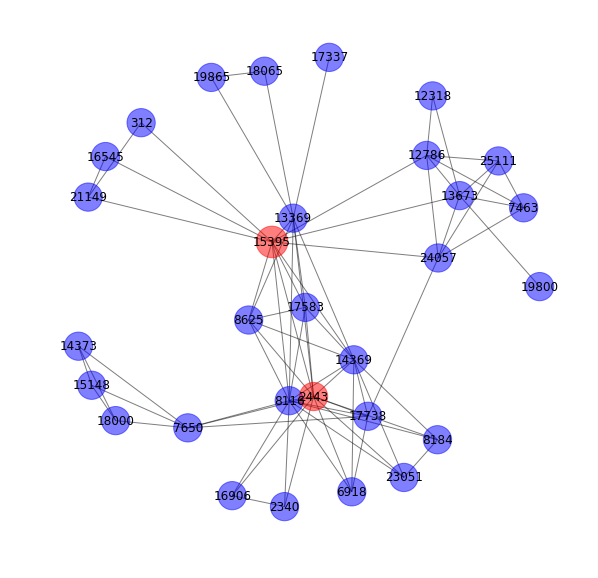

In [34]:
pair = set([author, '15395'])
plot_subgraph(get_subgraph(graph, pair, n=30), pair)

# Approaches

 6.) **Preferential attachment:** $$|N(X)| \times |N(Y)|$$
 
 
 <br><br>
 What will this do?
 
 <br><br><br>
 - Typically not used on its own, but could be used in combination with other functions to prefer links to more popular nodes.

In [ ]:
#harish

# Approaches

**Idea:** two nodes are similar if they have similar neighbors

 7.) **SimRank:** $$s(X,Y) = \gamma \frac{\sum_{A \in N(X)} \sum_{B \in N(Y)}s(A,B)}{|N(X)| \cdot |N(Y)|}$$
 
 $\gamma \in [0, 1]$ is a tuning parameter.
 
- Recursive definition

<br>
<br>

Solve iteratively:
<br>
- Start with fixed initial score for all pairs
- Update all score at same time
- Renormalize scores
- Repeat
 <br><br><br><br>
 
Advantage?
- Nodes can be similar even if they have zero common neighbors

<br><br>

# Evaluation

**How can I tell which method is best?**

<br><br><br><br>


# Train/Test evaluation

1. Create $G'$ by removing $n$ edges $E$ from $G$ at random.
  - $G'$ is the **training** network
  - $G$ is the **testing** network
2. Score all potential edges to add in $G'$.
3. Return $\hat{E}$, the top $n$ edges with highest score.
4. Compute the fraction of predicted edges that are in $G$:
$$\frac{|\hat{E} \cap E|}{|E|}$$

In [40]:
# Evaluate Adar using train/test
import random
random.seed(123)

def sample_edges(graph, node, pct=.5):
    """ Randomly remove some edges for node.
    Return:
      the resulting graph G'
      the list of friends of node whose edges were removed.
    """
    edges = list(graph.edges([node]))
    # Sample edges to remove.
    to_remove = random.sample(edges, int(len(edges) * pct))
    # Create the list of friends whose edges we have removed.
    friends = []
    for x in to_remove:
        if x[0] != node:
            friends.append(x[0])
        else:
            friends.append(x[1])
    print('removing %d edges' % len(to_remove))
    # Copy G into G' and remove the edges.
    graph_cp = graph.copy()
    graph_cp.remove_edges_from(to_remove)
    return graph_cp, friends

train_graph, friends = sample_edges(graph, author, pct=.5)
prediction = rank_by_adar(train_graph, author)[1:7]
print('adar rank=', prediction)
print('true neighbors=', friends)
n_correct = len(set(friends) & set([x[0] for x in prediction]))
print('Adar finds %d/%d for accuracy of %.3f' %
      (n_correct, len(friends),
      (n_correct / len(friends))))

removing 6 edges
adar rank= [('8116', 6.617672094422139), ('14369', 5.748620816213971), ('13369', 3.980347403807836), ('8625', 3.980347403807836), ('23051', 3.429585834283922), ('15395', 3.053718995778709)]
true neighbors= ['2340', '6918', '13369', '23051', '8625', '16906']
Adar finds 3/6 for accuracy of 0.500


In [ ]:
#harish: precision, recall